# How to use Xarray accessor
This example shows how to use the SpatialData accessor to extend the capabilities of xarray.

To extend xarray.DataArray you need only to load also pymepps with "import pymepps". The extensions could be used with the property xarray.DataArray.pp

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pymepps

To use the full power of pymepps, you have to set a grid. If you load the data with the xarray functions you have to set the grid afterwards. So the next step is to load a NetCDF model file with xarray. There are also pymepps functions to load model data. These are shown in another example.

In [2]:
ds = xr.open_dataset('../data/model/GFS_Global_0p25deg_20161219_0600.nc')
t2m_max = ds['Maximum_temperature_height_above_ground_Mixed_intervals_Maximum']
print(t2m_max)

<xarray.DataArray 'Maximum_temperature_height_above_ground_Mixed_intervals_Maximum' (time: 1, height_above_ground: 1, lat: 721, lon: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * time                 (time) datetime64[ns] 2016-12-19T09:00:00
  * height_above_ground  (height_above_ground) float32 2.0
  * lat                  (lat) float32 90.0 89.75 89.5 89.25 89.0 88.75 88.5 ...
  * lon                  (lon) float32 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 ...
Attributes:
    long_name:                       Maximum temperature (Mixed_intervals Max...
    units:                           K
    abbreviation:                    TMAX
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Maximum
    Grib_Variable_Id:                VAR_0-0-4_L103_Imixed_S2
    Grib2_Parameter:                 [0 0 4]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:         

The grid definition is inspired by the climate data operators. So you could either generate your own grid (done in this example), or you could load a cdo-conform grid file.

We could see that the grid is a structured latitude and longitude grid with a resolution of 0.25 degree.

In [3]:
grid_dict = dict(
    gridtype='lonlat',
    xsize=t2m_max['lon'].size,
    ysize=t2m_max['lat'].size,
    xfirst=t2m_max['lon'].values[0],
    xinc=0.25,
    yfirst=t2m_max['lat'].values[0],
    yinc=-0.25,
)

We created our grid dict with the information. Now we have to build the grid. In pymepps you could use the GridBuilder to build the grid with given grid_dict.

In [4]:
builder = pymepps.GridBuilder(grid_dict)
grid = builder.build_grid()
print(grid)

LonLatGrid
----------
gridtype = lonlat
xlongname = longitude
xname = lon
xunits = degrees
ylongname = latitude
yname = lat
yunits = degrees
xsize = 1440
ysize = 721
xfirst = 0.0
xinc = 0.25
yfirst = 90.0
yinc = -0.25


The next step is to set the grid for our dataset. For this we could use the set_grid method of the SpatialAccessor.

In [5]:
t2m_max = t2m_max.pp.set_grid(grid)
print(t2m_max.pp.grid)

LonLatGrid
----------
gridtype = lonlat
xlongname = longitude
xname = lon
xunits = degrees
ylongname = latitude
yname = lat
yunits = degrees
xsize = 1440
ysize = 721
xfirst = 0.0
xinc = 0.25
yfirst = 90.0
yinc = -0.25


Now we set the grid. It is also possible to normalize the coordinates to allow a consistent processing of the model data. 

In [6]:
# Before normalization
print('Before:\n{0:s}\n'.format(str(t2m_max)))

t2m_max = t2m_max.pp.normalize_coords()
# After normalization
print('After:\n{0:s}'.format(str(t2m_max)))

Before:
<xarray.DataArray 'Maximum_temperature_height_above_ground_Mixed_intervals_Maximum' (time: 1, height_above_ground: 1, lat: 721, lon: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * time                 (time) datetime64[ns] 2016-12-19T09:00:00
  * height_above_ground  (height_above_ground) float32 2.0
  * lat                  (lat) float64 90.0 89.75 89.5 89.25 89.0 88.75 88.5 ...
  * lon                  (lon) float64 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 ...
Attributes:
    long_name:                       Maximum temperature (Mixed_intervals Max...
    units:                           K
    abbreviation:                    TMAX
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Maximum
    Grib_Variable_Id:                VAR_0-0-4_L103_Imixed_S2
    Grib2_Parameter:                 [0 0 4]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name: 

We could see that the height_above_ground and the time variable are renamed to a more common name. The ensemble member is set to the default value 'det', while the runtime is set to the missing value None. Now lets plot the data with the xarray internal plot method.

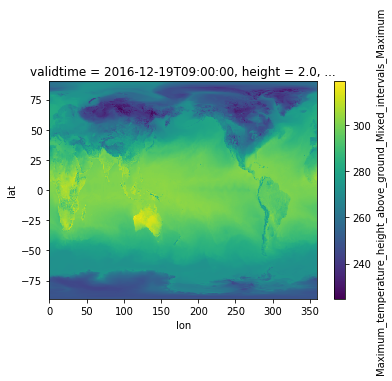

In [7]:
t2m_max.plot()
plt.show()

Lets make use of the SpatialAccessor to slice an area over germany. We would also transform the temperature unit to degree celsius. For this we could use the normal xarray.DataArray mathematical operations. After the transformation lets plot the temperature.

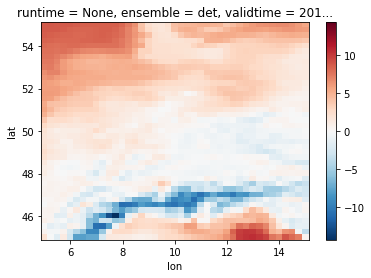

In [8]:
# sphinx_gallery_thumbnail_number = 2
ger_t2m_max = t2m_max.pp.sellonlatbox([5, 55, 15, 45])
# K to deg C
ger_t2m_max -= 273.15
ger_t2m_max.plot()
plt.show()

If we use a xarray.DataArray method where the DataArray instance is copied, we have to set a new grid. This behaviour coud seen in the following code block.

In [9]:
stacked_array = t2m_max.stack(stacked=('runtime', 'validtime'))
# we have to catch the error for sphinx documentation
try:
    print(stacked_array.pp.grid)
except TypeError:
    print('This DataArray has no grid defined!')

This DataArray has no grid defined!


This seen behavior arises from the fact that the grid is depending on the grid coordinates of the DataArray and they could be changed with a xarray.DataArray method.